# **Segmentation – Basics**

In this notebook on segmentation, we will learn how to segment hematological images using different approaches. In a first step, we try to segment the cells using simple thresholding.

Note that several of the topics discussed in this notebook are also covered 
in this insightful tutorial for this ImageJ/Fiji plugin [MorphoLibJ](https://imagej.net/plugins/morpholibj)

---

## **Preparations**

Let's begin with the usual preparatory steps...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import PIL

# Jupyter / IPython configuration:
# Automatically reload modules when modified
%load_ext autoreload
%autoreload 2

# Enable vectorized output (for nicer plots)
%config InlineBackend.figure_formats = ["svg"]

# Inline backend configuration
%matplotlib inline

# Enable this line if you want to use the interactive widgets
# It requires the ipympl package to be installed.
#%matplotlib widget

import sys
sys.path.insert(0, "../")
import tools

Here, too, we will work with the same images as before in the notebook on pre-processing:

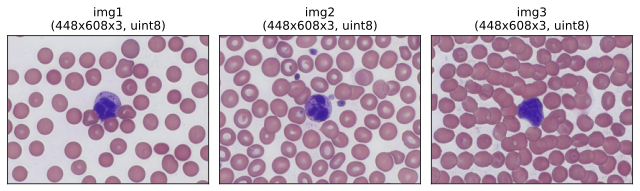

In [2]:
# Read in the data
img1 = cv.imread("../data/images/hematology-baso1.jpg", cv.IMREAD_COLOR)
img2 = cv.imread("../data/images/hematology-baso2.jpg", cv.IMREAD_COLOR)
img3 = cv.imread("../data/images/hematology-blast1.jpg", cv.IMREAD_COLOR)

img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
img3 = cv.cvtColor(img3, cv.COLOR_BGR2RGB)

tools.show_image_chain([img1, img2, img3], titles=["img1", "img2", "img3"])


---

## **Thresholding**

We can segment images using basic thresholding techniques. In this example, we explore the different thresholding methods available in OpenCV:
- Simple thresholding (use [`cv.threshold()`](https://docs.opencv.org/4.x/d7/d1b/group__imgproc__misc.html#gae8a4a146d1ca78c626a53577199e9c57), use flag `cv.THRESH_BINARY` or `cv.THRESH_BINARY_INV`)
- Adaptive thresholding (use [`cv.adaptiveThreshold()`](https://docs.opencv.org/4.x/d7/d1b/group__imgproc__misc.html#ga72b913f352e4a1b1b397736707afcde3))
- Otsu's thresholding (use [`cv.threshold()`](https://docs.opencv.org/4.x/d7/d1b/group__imgproc__misc.html#gae8a4a146d1ca78c626a53577199e9c57), use flags `cv.THRESH_BINARY+cv.THRESH_OTSU`)

Thresholding segments pixels into either foreground or background based on their intensity values. Thresholding is therefore an instance of *binary* image segmentation. The algorithms work by comparing the intensity values of the pixels in an image with a threshold value. Pixels with intensity values greater than the threshold are classified as foreground pixels, while pixels with intensity values less than the threshold are classified as background pixels. The threshold value can be set manually or determined automatically.

As preparation, please read this documentation on segmentation methods in OpenCV: [Link](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html)



In [3]:
######################
###    EXCERISE    ###
######################

# Choose here the image to work with
img = img1.copy()

# 1) Summarize the three different thresholding techniques in own words. Which methods
#    use a global threshold, which ones apply a local threshold? 



Simple threshold has a global threshold.

Adaptive and Otsu has local threshold

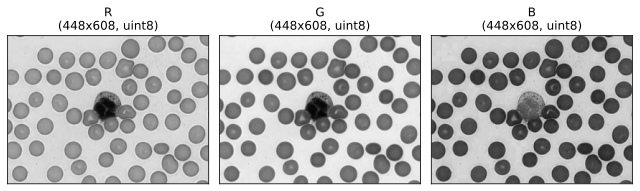

In [4]:


# 2) Develop a strategy to segment the white blood cells (purple), the red blood cells 
# (red) and the background (white/gray). You may want to exploit the fact that we have
# colors to work with:
tools.show_image_chain([img[:,:,0], img[:,:,1], img[:,:,2]], titles=["R", "G", "B"])




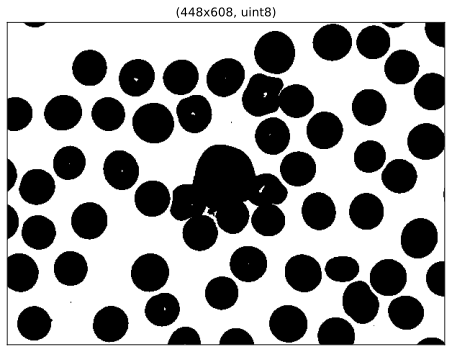

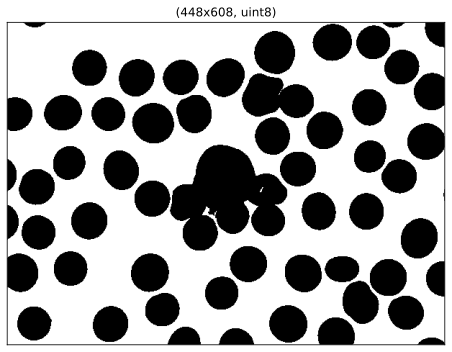

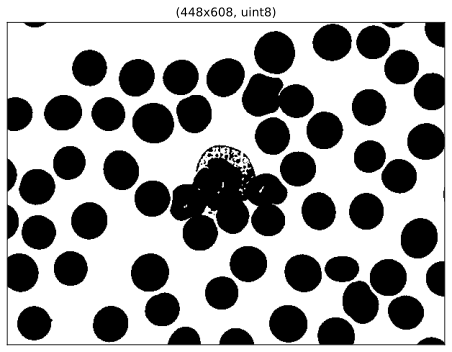

In [9]:
retR, thR = cv.threshold(img[:,:,0], 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
retG, thG = cv.threshold(img[:,:,1], 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
retB, thB = cv.threshold(img[:,:,2], 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
tools.show_image(thR)
tools.show_image(thG)
tools.show_image(thB)



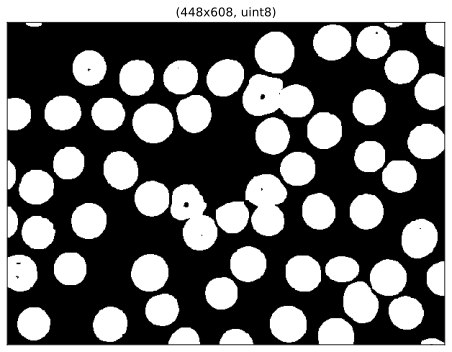

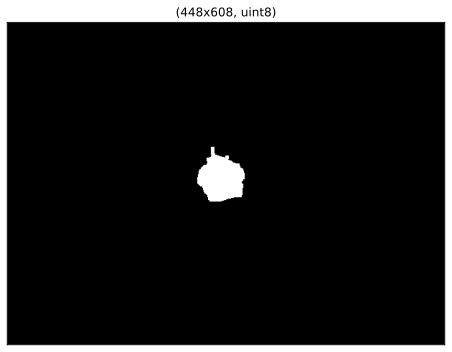

In [10]:
# Convert to HSV color space
hsv_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)

# Define range for purple color and then mask it
purple_lower = np.array([130, 40, 40])  # HSV lower range for purple
purple_upper = np.array([160, 255, 255])  # HSV upper range for purple
purple_mask = cv.inRange(hsv_img, purple_lower, purple_upper)

# Define range for red color and then mask it
red_lower1 = np.array([0, 70, 50])  # HSV lower range for red (lower band)
red_upper1 = np.array([10, 255, 255])  # HSV upper range for red (lower band)
red_lower2 = np.array([170, 70, 50])  # HSV lower range for red (upper band)
red_upper2 = np.array([180, 255, 255])  # HSV upper range for red (upper band)
red_mask1 = cv.inRange(hsv_img, red_lower1, red_upper1)
red_mask2 = cv.inRange(hsv_img, red_lower2, red_upper2)
red_mask = cv.bitwise_or(red_mask1, red_mask2)

# Morphological operations to clean up the masks
kernel = np.ones((3,3), np.uint8)
purple_mask = cv.morphologyEx(purple_mask, cv.MORPH_OPEN, kernel, iterations=2)
red_mask = cv.morphologyEx(red_mask, cv.MORPH_OPEN, kernel, iterations=2)


tools.show_image(purple_mask)
tools.show_image(red_mask)

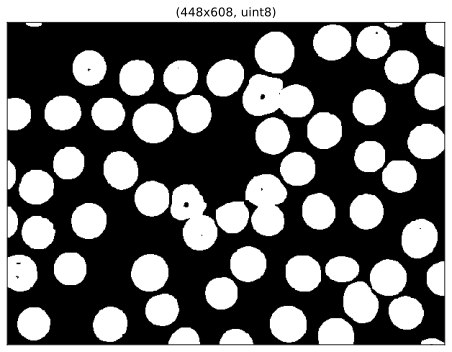

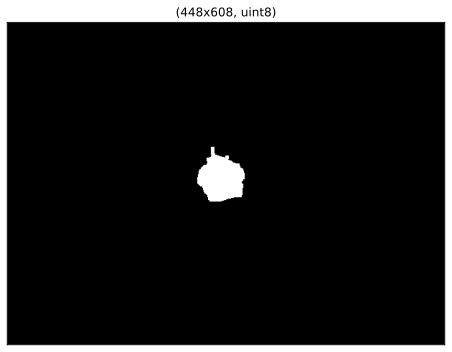

In [11]:
# Convert to HSV color space
hsv_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)

# Thresholding for purple (white blood cells)
# Isolating purple hues
purple_lower = np.array([130, 40, 40])
purple_upper = np.array([160, 255, 255])
purple_hue_mask = cv.inRange(hsv_img, purple_lower, purple_upper)
_, purple_mask = cv.threshold(purple_hue_mask, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

# Thresholding for red (red blood cells)
# Isolating red hues, considering the wrap around the hue value at 180
red_lower1 = np.array([0, 70, 50])
red_upper1 = np.array([10, 255, 255])
red_lower2 = np.array([170, 70, 50])
red_upper2 = np.array([180, 255, 255])
red_hue_mask1 = cv.inRange(hsv_img, red_lower1, red_upper1)
red_hue_mask2 = cv.inRange(hsv_img, red_lower2, red_upper2)
red_hue_mask = cv.bitwise_or(red_hue_mask1, red_hue_mask2)
_, red_mask = cv.threshold(red_hue_mask, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

# Morphological operations to clean up masks
kernel = np.ones((3,3), np.uint8)
purple_mask = cv.morphologyEx(purple_mask, cv.MORPH_OPEN, kernel, iterations=2)
red_mask = cv.morphologyEx(red_mask, cv.MORPH_OPEN, kernel, iterations=2)

tools.show_image(purple_mask)
tools.show_image(red_mask)

In [ ]:


# 3) Identify the different regions using thresholding
mask_wbc = ...
mask_rbc = ...
mask_bg = ...

# 4) Visualize the masks. Idea: combine the three masks into an RGB image.
mask_seg = ...

# 5) Discuss your results. What could be improved? What are the limitations of this 
#    approach? Are the masks mutually exclusive? Are they accurate?



---


## **Color clustering**

Instead of segmenting the image, we could also try to classify the different regions. For this, we can use a clustering algorithm such as [K-means](https://en.wikipedia.org/wiki/K-means_clustering). The algorithm works by classifying pixels in an image into clusters based on their color similarity. The similarity is measured using the (Eucledian or non-Euclidean) distance between the pixel values. The algorithm iteratively assigns pixels to clusters based on their distance to the cluster centers and updates the cluster centers based on the mean of the pixels in the cluster. The process continues until the cluster centers converge. See here for a nice [visualization](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/)) of the algorithm.

As a preparatory step, have a look at the following two tutorials:
- Machine Learning Master / Jason Brownlee on [color quantization](https://machinelearningmastery.com/k-means-clustering-in-opencv-and-application-for-color-quantization/)
- Shubhang Agrawal / Image segmentation using [k-means clustering](https://medium.com/swlh/image-segmentation-using-k-means-clustering-46a60488ae71) (the tutorial has a few flaws, please excuse). 



<!-- 
Resources:
# Nice way of depicting the bars
https://pyimagesearch.com/2014/05/26/opencv-python-k-means-color-clustering/
# OpenCV
https://docs.opencv.org/3.4/d1/d5c/tutorial_py_kmeans_opencv.html
# Machine Learning Mastery
https://machinelearningmastery.com/k-means-clustering-in-opencv-and-application-for-color-quantization/
# Watershed
https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html
# Segmentation with Skimage 
https://github.com/ipython-books/cookbook-2nd-code/blob/master/chapter11_image/03_segmentation.ipynb
# Combination between thresholding and color clustering
https://towardsdatascience.com/image-color-segmentation-by-k-means-clustering-algorithm-5792e563f26e
-->

In [ ]:
######################
###    EXCERISE    ###
######################

# Choose here the image to work with
img = img1

# 1) Reshape the color pixels into a Mx3 matrix (M: number of pixels)
#    and convert the data type to float32.
data = img.reshape(-1, 3).astype(np.float32)

# 2) Apply the K-means algorithm to the data. Use the cv.kmeans function.
#    Choose the number of clusters K=3.
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
ret, label, centers = cv.kmeans(data, K, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
# label contains the cluster index for each pixel
# centers contains the cluster centers (colors!)

# 3) Reshape and convert the data back to uint8
img_seg = ...

# 4) Visualize the segmented image
tools.show_image_pair(img, img_seg, title1="Original", title2="Segmented")

# 5) Repeat the process for a different color space (e.g. HSV)
#    Is the clustering more robust? Why? When does this approach fail?


---

## **Watershed algorithm for segmentation**

The watershed algorithm is a powerful tool for image segmentation. It is based on
the concept of watershed lines, which are lines that separate different regions in
an image. The algorithm works by flooding the image with "water" from different
regions (or seed points) and letting the water flow until it reaches a boundary. 
The watershed lines are then defined as the boundaries between the regions where
the water meets. The algorithm can be used to segment images into different regions
based on the intensity or color of the pixels. It is particularly useful for
segmenting images with complex shapes and structures.

Our dataset structurally resembles the image used in this [tutorial](https://learnopencv.com/k-means-clustering-in-opencv-cpp-python/). 
Let's use this demo naively to segment our image using the watershed method. 

The tutorial uses the following strategy: 
1. Convert the image into binary mask using thresholding
2. Apply so-called morphological operations\* to remove noise, and to separate the objects. We also use similar operations to identify regions that most likely represent the background of our scene.
3. with the next steps we aim to identify the seed points for the watershed algorithm
   1. Apply the distance transform\*\* to the binary image, which measures the distance of each pixel to the nearest zero pixel.
   2. Apply a threshold to the distance-transformed image to obtain blobs of pixels that are located close to the centers of our objects of interest.
   3. Use the connected components\*\*\* algorithm to identify and enumerate the different seed points. This turns 
  the binary mask into a mask with (integer) labeled objects.
   4. In a last step, mark the background seed regions (see step 2.) with label 0.
4. Fiinally, apply the watershed algorithm to segment the regions of interest.
5. Visualize the segmented image.


### \* **Morphological operations** 
Morphological operations are a set of operations that are used to analyze and manipulate
the shape of objects in an image. Although the operations are defined also for other types
of images, they are most commonly used in binary images. The operations involve structuring
elements (kernels) that are used to probe the image and modify the pixel values based on the
interaction between the kernel and the image. The most common morphological operations are
dilation (expand the shapes), erosion (shrink the shapes), opening (dilation followed by
erosion), and closing (erosion followed by dilation). Morphological operations are used to 
remove noise, separate objects, and connect objects in an image. 

**Further reading**:
- OpenCV documentation. [Link](https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html)
- Beautiful illustration how morphological operations work: [Link](https://penny-xu.github.io/blog/mathematical-morphology)
- Wikipedia article on mathematical morphology. [Link](https://en.wikipedia.org/wiki/Mathematical_morphology)
- Blog post on morphological operations. [Link](https://towardsdatascience.com/7bcf1ed11756)

### \*\* Distance transform
The distance transform is useful for a variety of applications in image processing. It
permits to compute the distance of each pixel to the nearest boundary in a binary image.
Based on distance transforms, we can perform operations such as skeletonization, identify
geometric properties of objects or segment images. The algorithm works by iteratively 
propagating the distance values from the boundary pixels to the interior pixels. The 
distance is computed using a metric such as the Euclidean distance. It is relatively 
cheap to compute the distance transform.

**Further reading**
- Another application of the distance transform (in combination with watershed). [Link](https://docs.opencv.org/3.4/d2/dbd/tutorial_distance_transform.html)


### \*\*\* Connected components
Connected components in a binary image are regions of pixels that are touching each
other. In image processing, connected components are used to identify single objects 
in a segmentation mask. The connected components algorithm works by labeling each
pixel in the mask with a unique (integer) label based on the connectivity of the pixels. 

**Further reading**
- Wikipedia article on connected component labeling. [Link](https://en.wikipedia.org/wiki/Connected-component_labeling)

In [ ]:
######################
###    EXCERISE    ###
######################

img = img1

# Implement the approach lined out above. You can copy paste the code 
# from the above link and plug our image into it. Try to understand the
# code and the different steps. You may have to adjust the parameters
# to get a good segmentation result.

# https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html

...

---

## **AI driven segmentation**
Nowadays, deep learning is often used for image segmentation. The U-Net
architecture is a popular choice for this task. It is a convolutional
neural network that is particularly well suited for segmentation tasks.
The nnU-Net is a more advanced version of the U-Net that has been optimized
for medical image segmentation, and comes with self-adapting preprocessing
and postprocessing steps, where the network learns the optimal parameters
for the task at hand. It is available as a Python package and can be installed
via pip.

Although machine learning / artificial intelligence is not the focus of this
course, we can use such models to perform image segmentation. In contrast to 
the methods described above, deep learning models can learn the relevant 
features from the data and can generalize to unseen data. However, these methods
require large amounts of labeled data for training, and are computationally
more expensive. They are also often considered as "black boxes", as it is
difficult to understand why the model makes a certain decision.

```python
######################
###    EXCERISE    ###
######################
```

Visit the following resources and examine if they could be useful for your own segmentation project.
- Segment anything by Meta AI. [Demo](https://segment-anything.com/demo), [Paper](https://arxiv.org/abs/2304.02643), [Code](https://github.com/facebookresearch/segment-anything) 
- Huggingface: Collection of public, pre-trained models. [Link](https://huggingface.co/spaces).
  - Some models come with a demo interface. 
  - For instance, the background removal [RemBG](https://huggingface.co/spaces/KenjieDec/RemBG) tool is found there.
  - Another popular segmentation tool is [Demo](https://huggingface.co/spaces/fcakyon/yolov8-segmentation), [Code](https://huggingface.co/spaces/fcakyon/yolov8-segmentation)
  - To search the entire database for models: [Link](https://huggingface.co/models)
- Total segmentator for anatomical CT data. [Demo](https://totalsegmentator.com/), [Paper](https://arxiv.org/abs/2208.05868), [Code](https://github.com/wasserth/TotalSegmentator)


We have seen now a couple of approaches to segment images. How you can make best
use of them depends on the specific problem and your engineering skills. 😊